In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.backend_bases import RendererBase
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
#from tensorboardX import SummaryWriter
from transformers import BertModel, BertTokenizer
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import torch
from tqdm import tqdm
import csv
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertConfig
from sklearn.metrics import f1_score
import json

In [2]:
class_names = ['joy', 'sadness', 'fear', 'anger', 'neutral']

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  

cuda:0


In [5]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(class_names),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('./model/online.pt', map_location=torch.device('cpu')))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [13]:
def predict_emotion_user(path_file):
    user_name = path_file.split('.')[0]
    class_names = ['joy', 'sadness', 'fear', 'anger', 'neutral']
    result_dict = {'joy':0, 'sadness':0, 'fear':0, 'anger':0, 'neutral':0}
    joy_list = []
    sadness_list = []
    fear_list = []
    anger_list = []
    neutral_list = []
    #max_ind = np.zeros((5,5))
    with open(path_file) as f:
        contents = f.readlines()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(class_names),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
    model.to(device)
    model.load_state_dict(torch.load('./model/online.pt', map_location=torch.device('cpu')))
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    for sentence in contents:
        sentence = sentence[len(user_name)+2:]
        inputs = tokenizer(sentence, return_tensors="pt")
        outputs = model(**inputs.to(device))
        
        score = max(outputs[0].cpu().detach().numpy())
        joy_list.append(score[0])
        sadness_list.append(score[1])
        fear_list.append(score[2])
        anger_list.append(score[3])
        neutral_list.append(score[4])
        
        key = outputs[0].argmax().cpu().item()
        result_dict[class_names[key]]+=1
    max_emotion = max(result_dict, key=result_dict.get)
    
    for k,v in result_dict.items():
        print(k + ': ' + str(v))
        
    labels = result_dict.keys()
    sizes = result_dict.values()
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
    ax1.axis('equal') 
    plt.show()
    fig1.savefig(user_name + '_pie_result.PNG')
    
    with open(user_name + '_top5_result.txt', 'w') as f1:
        joy_ind = np.argsort(joy_list)[-5:]
        print('Top five sentence with a label of joy:')
        f1.write('Top five sentence with a label of joy:\n')
        for i in joy_ind:
            f1.write(contents[i])
            print(contents[i])
            #print('\n')
        
        sadness_ind = np.argsort(sadness_list)[-5:]
        print('Top five sentence with a label of sadness:')
        f1.write('Top five sentence with a label of sadness:\n')
        for i in sadness_ind:
            f1.write(contents[i])
            print(contents[i])
            #print('\n')
        
        fear_ind = np.argsort(fear_list)[-5:]
        print('Top five sentence with a label of fear:')
        f1.write('Top five sentence with a label of fear:\n')
        for i in fear_ind:
            f1.write(contents[i])
            print(contents[i])
            #print('\n')
        
        anger_ind = np.argsort(anger_list)[-5:]
        print('Top five sentence with a label of anger:')
        f1.write('Top five sentence with a label of anger:\n')
        for i in anger_ind:
            f1.write(contents[i])
            print(contents[i])
            #print('\n')
        
        neutral_ind = np.argsort(neutral_list)[-5:]
        print('Top five sentence with a label of neutral:')
        f1.write('Top five sentence with a label of neutral:\n')
        for i in neutral_ind:
            f1.write(contents[i])
            print(contents[i])
            #print('\n')
        
    with open(user_name + '_label_result.txt', 'w') as f2:
        f2.write(max(result_dict,key = result_dict.get))
            
    return result_dict
    #return max_emotion

In [16]:
import plotly.express as px
def radar_chart(emotion_dict, user_name):
    df = pd.DataFrame(dict(
    r=list(emotion_dict.values()),
    theta=list(emotion_dict.keys())))
    fig = px.line_polar(df, r='r', theta='theta', line_close=True)
    fig.show()
    fig.write_image(user_name + "_result_radar.PNG")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

joy: 1270
sadness: 1704
fear: 44714
anger: 2661
neutral: 9673


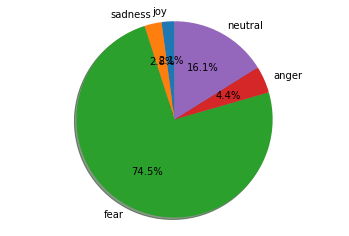

Top five sentence with a label of joy:
circus: HIS FACE LIT UP

circus: have a nice stay here:

circus: Have fun by yourselves

circus: AND DAWN WAS SO HAPPY THEY WERE LKKE AAA

circus: imagine how happy the north koreans would be

Top five sentence with a label of sadness:
circus:  THIS IS SO SAD

circus: This is so sad

circus: IM GONNA BE SO SAD I SWEAR

circus: I was so sad when she told me iron Man died I was like

circus: listening to my brother cry

Top five sentence with a label of fear:
circus: BRB GONNA HAVE A PANIC ATTACK ITS THE FOURTH WEEK OF SCHOOL AND I HAVEN'T BROKE ANY RULES

circus:  @circus trump do be concerned ab an app more then a pandemic @char.ur.daddy0420 ikr oml

circus:  @circus GOOOD IF ONLY SOMEONE CAN MUTE UNI BC HIS DUMBASS DOESNT KNOW I GET SCARED OR SUM @sharkpuppy LMAO

circus: hi enola lemme just scream at u @kaito AHHH kuki u heard me scream before?

circus:  @circus nah my teacher Presenting something weird rn @Ventura LMAO WHAT

Top five sentence w

In [20]:
#final = predict_emotion_user('muffins.txt')
#final = predict_emotion_user('Saysora.txt')
final = predict_emotion_user('circus.txt')

In [21]:
#radar_chart(final, 'muffins')
#radar_chart(final, 'Saysora')
radar_chart(final, 'circus')